<a href="https://colab.research.google.com/github/comparativechrono/covid-chronotyping/blob/main/rhesusnegative/Covid_association.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variant enrichment in 100K Covid-19 frequent release data using Fishers exact test

## Comparative chronomics group 
### October 2022

In [ ]:
# Install tidyverse if you have not got it installed

install.packages("tidyverse")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Run tidyverse library

library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# 1. Import data
We have downloaded and exported the PER3 VNTR chronotype alleles of the May 2020, August 2020 and April 2021 Genomics England data releases. The dataset consisted of the people who had been tested for covid, whether they were positive or negative, and whether they were hospitalised when they were tested. To explore the hypothesis that having a morning chronotype makes you more susceptible to catching the disease and having acute comparison we can perform some enrichment analysis. The dataset represents participants in the 100,000 genomes project (100KGP), so the control for the data is the chronotyping of the entire 100KGP.


First we will need to import our dataset for the analysis. IYou will need to replace the placeholder, shown in the example below, for each dataset. If there was an association we would expect to see it in the earlier releases. As of Dec 2021 1 in 6 people have officially had Covid-19, making the earlier datasets more likely to have greater power at picking genetic associations up.

In [ ]:
your_name <- read.table("[insert file name]]", sep = "\t", header = TRUE)

In [ ]:
head(your_name)

,group,V1,V2,V3,V4
,<chr>,<int>,<int>,<int>,<int>
1,Positive_vs_100K,72,18481,178,50893
2,acute_vs_100K,58,18495,126,50945
3,acute_vs_nonacute,58,14,126,52
4,covid+ve_vs_covid-ve,72,534,178,1384


The data you have imported are as a csv file. This file is in matrix format. Each row is a seperate 2x2 contingency table, in the format i,j. This is matrix nomenclature, essentially it means that each row needs to be split into a matrix to make a 2x2 table with the numbers first filling rows in the first columns, and then the second. The marker column is the particular chronotype marker identified in Jones et Al. These are dbSNP ID's.

This is shown below with an example from the first line of file 1A.

In [ ]:
test <- c(1015,2707,56102,95796)
matrix(unlist(test), nrow = 2)

1015,56102
2707,95796


So in our contingency table the columns represent people who have taken tests in the 100K, versus those who had not, and the rows represent alleles.

# 2. An example enrichment analysis

To analyse this data there are a number of approaches, the simplest is to use Fisher's exact test. The code cells below run Fishers against each of the 2x2 tables encoded in the csv files. The second code cell saves the results of the Fishers to an output file. Remember to change the name of the output file for the dataset comparison you are working on.

*The example analysis is just shown here for one of of datasets, you will need to repeat it for each of the CSV files, changing the names of the input files, and the name of the output files.*

In [ ]:
# Make list from csv file and run Fishers
analysis  <- your_name %>% 
  setNames(c("group", "V1","V2","V3","V4")) %>% 
  nest(-group) %>% 
  mutate(matrix = map(data, ~matrix(unlist(.x), nrow = 2))) %>% 
  mutate(fisher = map(matrix, ~fisher.test(.x))) %>% 
  mutate(stats = map(fisher, ~broom::glance(.x)))

Warning message:
“All elements of `...` must be named.
Did you want `data = c(V1, V2, V3, V4)`?”


In [ ]:
# Extract p value and odds ratio and write out to results file
analysis %>% 
  unnest(stats) %>%
  select(group, p.value, odds = estimate) %>% 
  write.csv("2A_fishers_results.csv")

## You can now download and open the file Fishers_results.csv in excel ##

If you do not know what p values and odds ratios are make sure you have a good read! You should ensure you understand what Fishers exact test is doing, and consider the structure of the 2x2 example table we looked at above.

The toy code below takes our theoretical contingency table above and runs it through Fishers, using the fisher.test function. Note the full output you are given. The code above extracts the p value and odds ratio for you from this output.

In [ ]:
testcont <- matrix(unlist(test), nrow = 2)
fisher.test(testcont)



	Fisher's Exact Test for Count Data

data:  testcont
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.5946564 0.6889285
sample estimates:
odds ratio 
  0.640248 


# 3. Make some graphs

In [ ]:
# If you prefer to work in R then this is the following type of analysis to do:
results <- analysis %>% 
  unnest(stats) %>%
  select(group, p.value, odds = estimate)

In [ ]:
head(results)

group,p.value,odds
<chr>,<dbl>,<dbl>
Positive_vs_100K,0.4313402,1.113885
acute_vs_100K,0.1336393,1.267971
acute_vs_nonacute,0.1533268,1.706277
covid+ve_vs_covid-ve,0.7645578,1.048329


There are a number of analyses that can be performed. The first is to graph the data in different ways, and see what it is telling us. Below are two basic graphs, you could consider making nicer ones in ggplot.

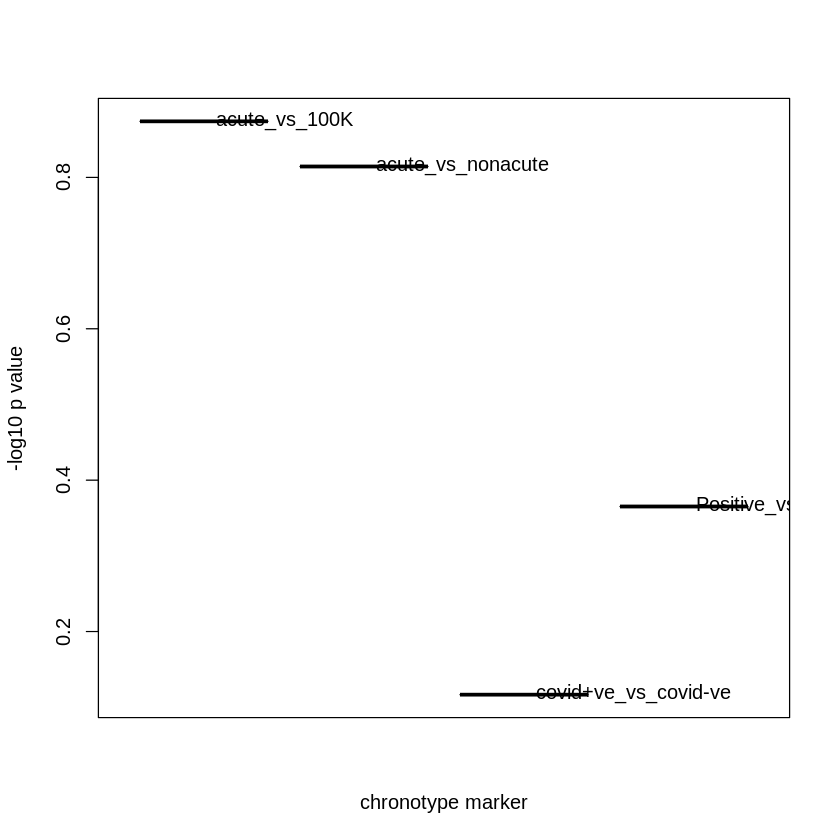

In [ ]:
# plot of -log of p value

# calculate the -l0g10 p value for plotting
y <- -log10(results$p.value)

## make a plot of the -log10 p vale
plot(as.factor(results$group), y, type = "p", xaxt='n', xlab = "chronotype marker", ylab = "-log10 p value")
# this threshold is set for multiple hypothesis testing for all the variants in the genome
threshold <- y > -log10(0.05/324000000)
## add a line for the threhold for clarity
abline(h = -log10(0.05/324000000), col = 'coral2', lwd = 1)
points(as.factor(results$group)[threshold], y[threshold], col="coral2")
text(as.factor(results$group), y, labels = results$group, pos = 4)

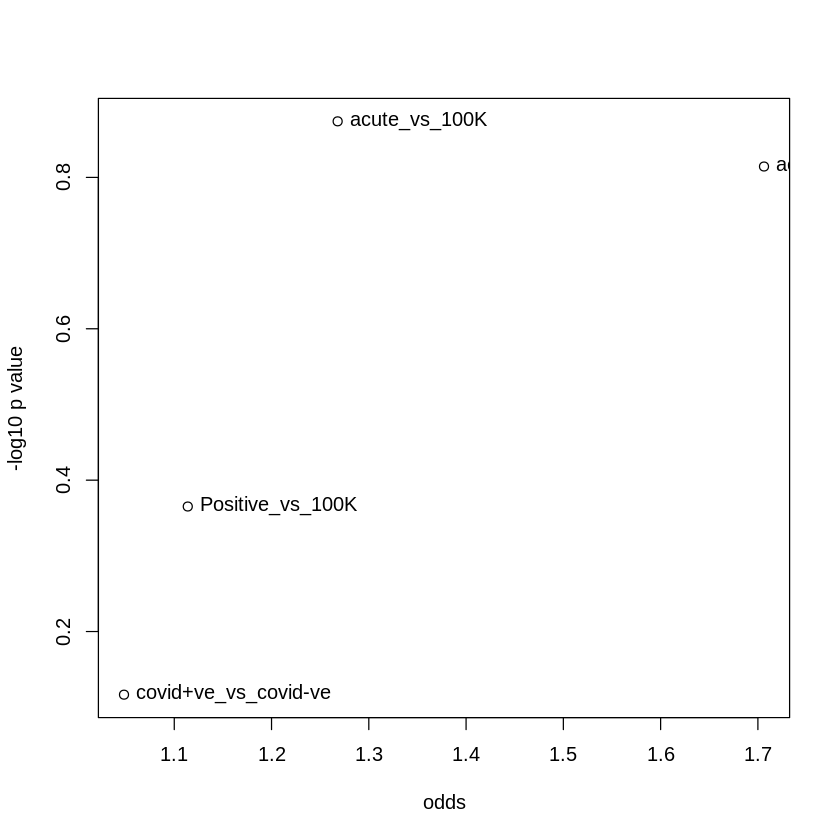

In [ ]:
# volcano plot

plot(results$odds, y, type = "p", xlab = "odds", ylab = "-log10 p value")
# this threshold is set for multiple hypothesis testing for all the variants in the genome - change as appropriate
threshold <- y > -log10(0.05/324000000)
## add a line for the threhold for clarity
abline(h = -log10(0.05/324000000), col = 'coral2', lwd = 1)
points(results$odds[threshold], y[threshold], col="coral2")
text(results$odds, y, labels = results$group, pos = 4)